# Анализ продаж компьютерных игр

Анализ продаж компьтерных игр для интернет-магазина "Стримчик".

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation) с 1980 по 2016 годы.

**Цель исследования:** выявить определяющие успешность игры закономерности для того, чтобы сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np

In [ ]:
data = pd.read_csv('/datasets/games.csv')

In [ ]:
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


## Предобработка данных

Так как названия столбцов не соответствуют общепринятому формату, приведем их к нижнему регистру:

In [ ]:
data.columns = data.columns.str.lower()

Далее, преобразуем данные в нужные типы, где это необходимо:

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [ ]:
#замени столбец с данными о годе выпуска игры на целочисленный
data['year_of_release'] = data['year_of_release'].astype('Int64')

Также стоит заменить тип данных в столбце 'user_score'. Сделаем это после обработки пропусков:

In [ ]:
#количество пропусков в каждом столбце
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Так как в столбцах 'name' и 'year_of_release' незначительное количество пропущенных значений, было принято решение удалить строки, где они присутствуют.

In [ ]:
data = data.dropna(subset=['name'])

In [ ]:
data = data.dropna(subset=['year_of_release'])

В столбце 'user_score', описывающем пользовательскую оценку игры, присутствует значение "tbd", которое расшифровывается, как To Be Determined, то есть "Будет определено" (также употребляется в значение To Be Done или To Be Discussed). Это означает, что оценка пользователей по тем или иным причинам у игры отсутствует, поэтому заменим все значения tbd на NaN, а также изменим тип данных на float:

In [ ]:
data['user_score'] = data['user_score'].replace('tbd', 'nan').astype('float')

Оставшиеся пропуски в столбцах 'critic_score' и 'user_score' (оценка критиков и пользователей) заполнять не считается корректым, так как ни медианное, ни среднее значение могут не соответствовать реальному мнению критиков и пользователей об игре и это может повлиять на дальнейшее исследование.

In [ ]:
#проверим оставшиеся пропуски
data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating             6676
dtype: int64

In [ ]:
#проверим на наличие дубликатов
data.duplicated().sum()

0

In [ ]:
#обновим индексы датафрйма
data = data.reset_index(drop=True)

Создадим столбец с суммариными продажами по всем регионам

In [ ]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']


Возможными причинами пропусков в данных в столбцах 'name' (название игры) и 'year_of_release' (год выпуска) можно назвать случайные человеческие или технические ошибки, в результате чего в датасет либо просто не внесли необходимы данные, либо они были утерены в результате обработки, выгрузки и тд. Пропуски в столбцах 'critic_score' и 'user_score' (оценки критиков и пользователей соответственно) могли возникнуть также в следствии случайных причин, но и, например, из-за того, что игра слишком новая и еще не имеет оценок на момент выгрузки. В столбце 'rating' (рейтинг ESRB) пропуски могли возникнуть в связи с тем, что данный рейтинг не присваивается в некоторых регионах и не присваивался до 1994 года.

In [ ]:
#data[data['critic_score'].isna()].head(20)

In [ ]:
# Комментарий ревьюера
# Посмотрим, что осталось
temp = data.copy()
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().mean()*100,2),'%')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           9768 non-null   object 
 11  total_sales      16444 non-null  float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.5+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio' 'uDraw Studio: Instant Artist'
 '¡Shin Chan Flipa en colores!']
n



Из открытых источников известно, что рейтинг ESRB - негосударственная организация, основное направление деятельности — принятие и определение рейтингов для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде. Также стало известно, что данная организация начала свою деятельность только в 1994 году, а в предоставлекнном датасете данные, начиная с 1980 года. Поэтому пропуски в данном столбце могут быть вызваны тем, что в определенном регионе и для игр страше 1994 года выпуска рейтинг не присваивался.

Поставим заглушку на пропуски в столбце с рейтингом ESRB, чтобы не потерять и учесть эти данные при дальнейшем анализе:

In [ ]:
data['rating'] = data['rating'].fillna('no_rating')

## Исследовательский анализ

Посмотрим, сколько игр выпускалось в разные годы:

In [ ]:
dt_year = data.groupby('year_of_release')['name'].agg('count')
dt_year

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     653
2013     544
2014     581
2015     606
2016     502
Name: name, dtype: int64

Text(0.5, 1.0, 'Распределение выпущенных игр по годам')

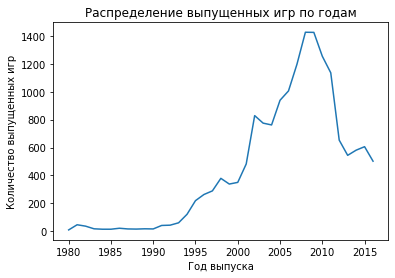

In [ ]:
dt_year.plot(x='year_of_release')
plt.xlabel('Год выпуска')
plt.ylabel('Количество выпущенных игр')
plt.title('Распределение выпущенных игр по годам')

<AxesSubplot:>

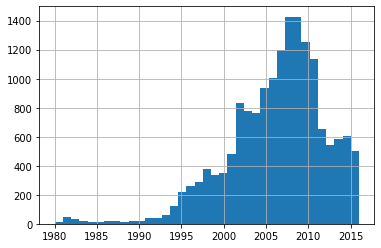

In [ ]:
data['year_of_release'].hist(bins=37)

Можно заметить, что выпуск игр постепенно увеличивался, пока не достиг своего пика в 2008-2009 годах. После чего, количество выпускаемых игр начало стремительно уменьшатся и сейчас примерно равно уровню 2001 года.

Это можно связать с тем, что в последние годы предъявляется гораздо больше требований к качеству новых игр, что требует более длительного и сложного процесса разработки. Поэтому выпускается меньшее количество, но гораздо более масштабных и качественных игр.

Посмотрим, как менялись продажи по платформам:

In [ ]:
#10 платформ с наибольшими суммарными продажами
dt_pl_top10 = data.groupby('platform')['total_sales'].agg('sum').sort_values(ascending=False).head(10)
dt_pl_top10

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.78
PS       727.58
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
Name: total_sales, dtype: float64

In [ ]:
pl_top = pd.Series(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP', '3DS'])

<AxesSubplot:xlabel='year_of_release'>

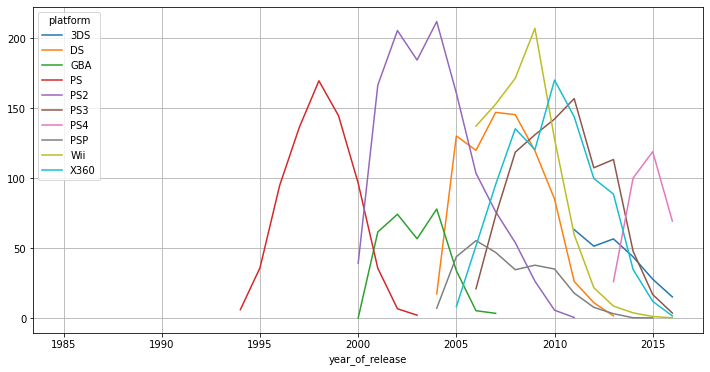

In [ ]:
#распределение платформ с наибольшими суммарными продажами по годам
(data
    .query('platform.isin(@pl_top)')
    .pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
    .sort_values('year_of_release', ascending=False)
).plot(figsize=(12, 6), grid=True)

Появляются новые и исчезают старые платформы в срок примерно от 7 до 12 лет. При этом до 1994 года не появлялась ни одна из наиболее прибыльных платформ, поэтому рассмотрим более подробно период с 1994 года:

In [ ]:
data2 = data[data['year_of_release'] > 1993]

<AxesSubplot:xlabel='year_of_release'>

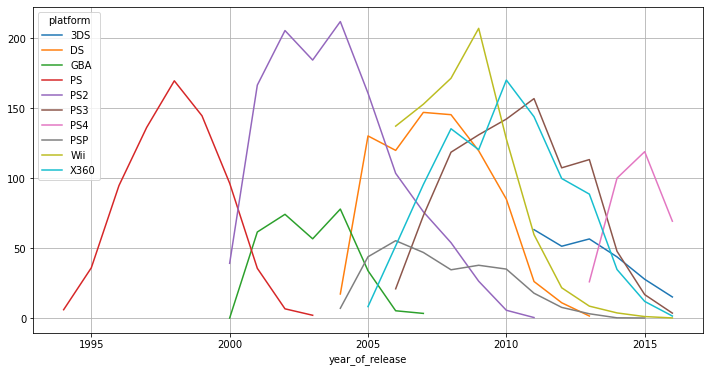

In [ ]:
(data2
    .query('platform.isin(@pl_top)')
    .pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
    .sort_values('year_of_release', ascending=False)
).plot(figsize=(12, 6), grid=True)

Можно увидеть, что на текущий момент (2016 год) все еще актуальными (из наиболее прибыльных платформ за весь рассматриваемый период) остались такие платформы, как: PS4, 3DS, PS3, X360 и Wii. Однако, многие из них, уже прошли период пика своих продаж , поэтому назвать их перспективными нельзя.

Посмотрим же, какие платформы лидируют по продажам в настоящее время (возьмем 2015 год, так как за 2016 представлены неполные данные):

In [ ]:
dt_pl15 = data[data['year_of_release'] == 2015]
dt_pl15.groupby('platform')['total_sales'].agg('sum').sort_values(ascending=False)

platform
PS4     118.90
XOne     60.14
3DS      27.78
PS3      16.82
WiiU     16.35
X360     11.96
PC        8.52
PSV       6.25
Wii       1.14
PSP       0.12
Name: total_sales, dtype: float64

In [ ]:
persp_platform = pd.Series(['PS4', 'XOne', '3DS', 'PS3', 'WiiU', 'X360', 'PC', 'PSV', 'Wii', 'PSP'])

<AxesSubplot:xlabel='year_of_release'>

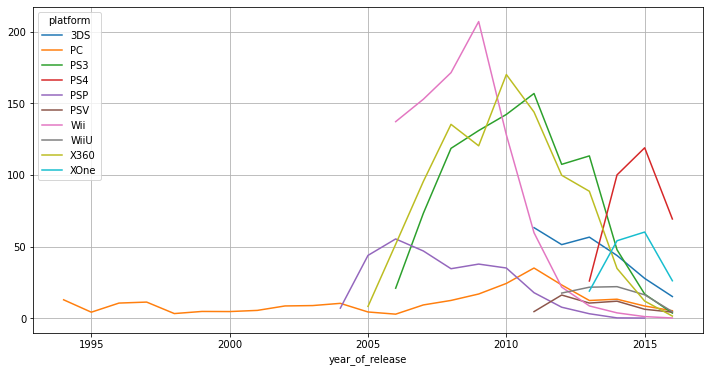

In [ ]:
(data2
    .query('platform.isin(@persp_platform)')
    .pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
    .sort_values('year_of_release', ascending=False)
).plot(figsize=(12, 6), grid=True)

Игры, которые находятся в топ по продажам в 2015 году, как в последнем периоде с полными данными, PS4, XOne, 3DS, WiiU, были выпущены не позднее 2011 года и имеют перспективу дальнейшего роста. Поэтому возмьмем за актуальный период данные за послдение  5 лет, с 2011 по 2016 года. Также, стоит добавить в этот список PC (ПК), так как, хоть она и не находится в топе по продажам в настоящий момент, эта платформа очень стаблильна в течение всего рассматриваемого периода, а значит может являться безопасным вложением с минимальными рисками.

In [ ]:
best_plat = pd.Series(['PS4', 'XOne', '3DS', 'WiiU', 'PC'])

In [ ]:
data_new = data[data['year_of_release'] >= 2013]
data_new.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,no_rating,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,no_rating,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62


Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам:

In [ ]:
#старый вариант
#data_new.query('platform.isin(@best_plat)').boxplot(column='total_sales', by='platform', figsize=(10, 10))
#plt.ylim(0, 3)

<AxesSubplot:title={'center':'total_sales'}, xlabel='platform'>

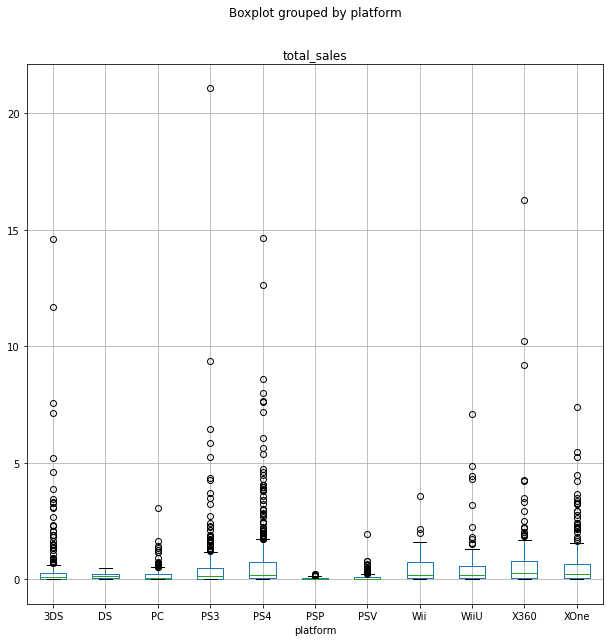

In [ ]:
data_new.boxplot(column='total_sales', by='platform', figsize=(10, 10))

(0.0, 2.0)

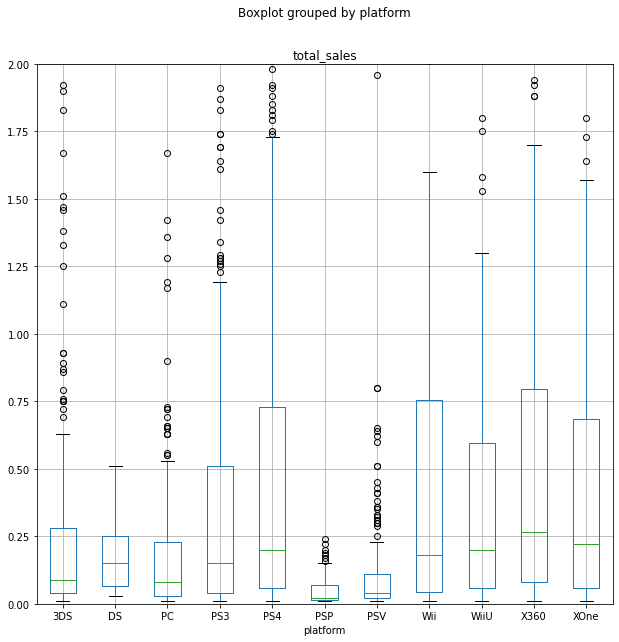

In [ ]:
data_new.boxplot(column='total_sales', by='platform', figsize=(10, 10))
plt.ylim(0, 2)


Максимальную медиану продаж можно наблюдать у платформы X360 (0,26 миллионов), а также один из самых продаваемых "выбросов" (около 16-17 миллионов копий). В остальном, медианные продажи не превышают 0,2 млн проданных копий, но платформы получают многомиллионные продажи от "игр-выбросов" (т.е. игр-бестселлеров). Наименьшие же мединанные продажи наблюдаются у платформ PSP и PSV.

Влияние на продажи внутри одной платформы отзывов пользователей и критиков:

<AxesSubplot:xlabel='critic_score', ylabel='total_sales'>

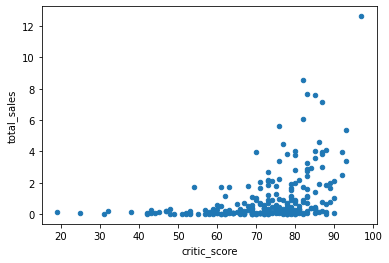

In [ ]:
#влияние оценок критиков PS4
data_ps4 = data_new[data_new['platform'] == 'PS4']
data_ps4.plot(x='critic_score', y='total_sales', kind='scatter')

In [ ]:
data_ps4['critic_score'].corr(data_ps4['total_sales'])

0.40656790206178095

<AxesSubplot:xlabel='user_score', ylabel='total_sales'>

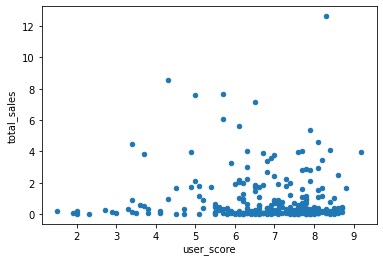

In [ ]:
#влияние оценок пользователей PS4
data_ps4.plot(x='user_score', y='total_sales', kind='scatter')

In [ ]:
data_ps4['user_score'].corr(data_ps4['total_sales'])

-0.031957110204556376

<AxesSubplot:xlabel='critic_score', ylabel='total_sales'>

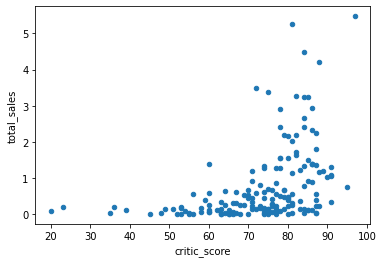

In [ ]:
#XOne
data_xone = data_new[data_new['platform'] == 'XOne']
data_xone.plot(x='critic_score', y='total_sales', kind='scatter')

In [ ]:
data_xone['critic_score'].corr(data_xone['total_sales'])

0.4169983280084017

<AxesSubplot:xlabel='user_score', ylabel='total_sales'>

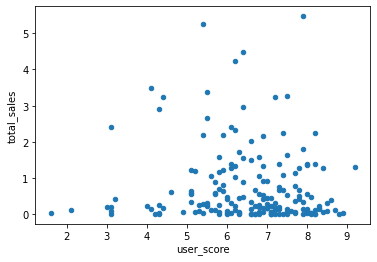

In [ ]:
data_xone.plot(x='user_score', y='total_sales', kind='scatter')

In [ ]:
data_xone['user_score'].corr(data_xone['total_sales'])

-0.06892505328279414

<AxesSubplot:xlabel='critic_score', ylabel='total_sales'>

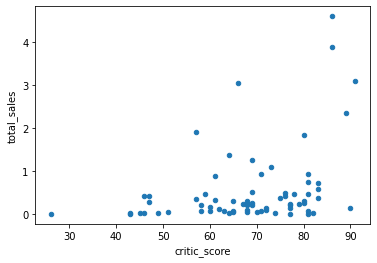

In [ ]:
#3DS
data_3ds = data_new[data_new['platform'] == '3DS']
data_3ds.plot(x='critic_score', y='total_sales', kind='scatter')

In [ ]:
data_3ds['critic_score'].corr(data_3ds['total_sales'])

0.3570566142288103

<AxesSubplot:xlabel='user_score', ylabel='total_sales'>

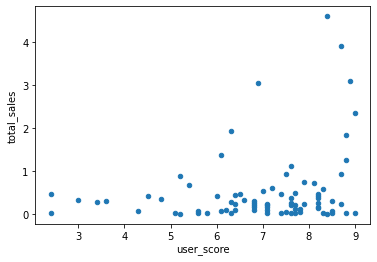

In [ ]:
data_3ds.plot(x='user_score', y='total_sales', kind='scatter')

In [ ]:
data_3ds['user_score'].corr(data_3ds['total_sales'])

0.24150411773563016

<AxesSubplot:xlabel='critic_score', ylabel='total_sales'>

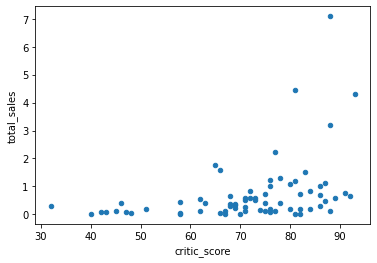

In [ ]:
#WiiU
data_wiiu = data_new[data_new['platform'] == 'WiiU']
data_wiiu.plot(x='critic_score', y='total_sales', kind='scatter')

In [ ]:
data_wiiu['critic_score'].corr(data_wiiu['total_sales'])

0.3764149065423912

<AxesSubplot:xlabel='user_score', ylabel='total_sales'>

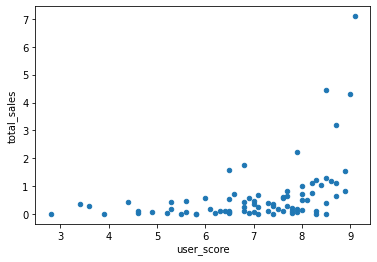

In [ ]:
data_wiiu.plot(x='user_score', y='total_sales', kind='scatter')

In [ ]:
data_wiiu['user_score'].corr(data_wiiu['total_sales'])

0.4193304819266187

<AxesSubplot:xlabel='critic_score', ylabel='total_sales'>

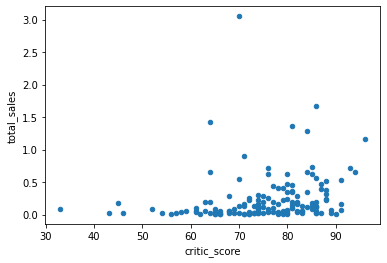

In [ ]:
#PC
data_pc = data_new[data_new['platform'] == 'PC']
data_pc.plot(x='critic_score', y='total_sales', kind='scatter')

In [ ]:
data_pc['critic_score'].corr(data_pc['total_sales'])

0.19603028294369382

<AxesSubplot:xlabel='user_score', ylabel='total_sales'>

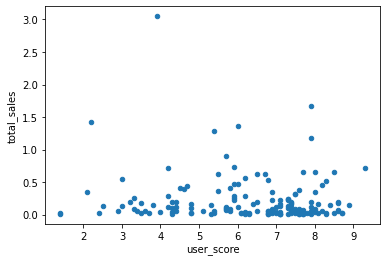

In [ ]:
data_pc.plot(x='user_score', y='total_sales', kind='scatter')

In [ ]:
data_pc['user_score'].corr(data_pc['total_sales'])

-0.0938418695247674

В общем, изучив полученные диаграммы и коэффициенты, можно сказать, что оценки пользователей практически не влияют на продажи игр на той или иной платформе. Исключение составляют разве что платформы WiiU и 3DS (коэффициенты 0,4 и 0,2 соответственно), однако связь все равно умеренная и даже довольно слабая. У многих платформ наблюдается даже обратная связь (чем ниже оценка пользователей, тем больше продажи), хотя коэффициент и слишком мал, чтобы говорить о какой либо зависимости.
Оценки критиков имеет немного большее влияние на продажи, в среднем коэффициент корреляции равен 0,37 (умеренная связь)

Посмотрим на общее распределение игр по жанрам:

In [ ]:
genre_gr = data_new.groupby('genre')['total_sales'].agg(['count', 'sum']).sort_values(by='sum', ascending=False)
genre_gr

,count,sum
genre,,
Action,766,321.87
Shooter,187,232.98
Sports,214,150.65
Role-Playing,292,145.89
Misc,155,62.82
Platform,74,42.63
Racing,85,39.89
Fighting,80,35.31
Adventure,245,23.64


<AxesSubplot:xlabel='genre'>

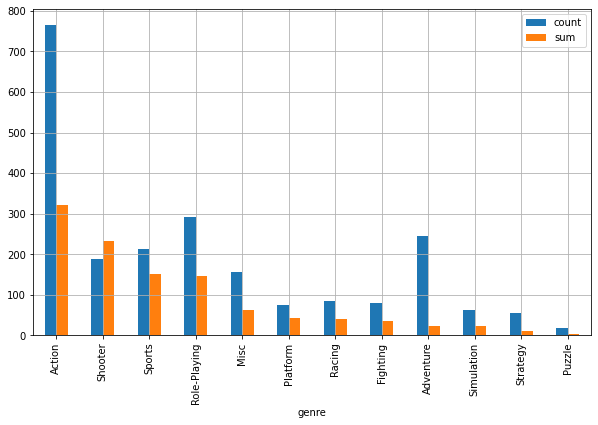

In [ ]:
genre_gr.plot(kind='bar', grid=True, figsize=(10, 6))

Самыми прибыльными в период с 2011 по 2016 годы являются такие жанры, как Action, Shooter, Role-Playing и Sports. Наибольшее же количество игр продается в жанрах Action, Role-Playing и Adventure. Хуже всех продаются игры, относящиеся к жанрам Puzzle и Strategy.

In [ ]:
genre_gr = data_new.groupby('genre')['total_sales'].agg('median').sort_values(ascending=False)
genre_gr

genre
Shooter         0.450
Sports          0.240
Platform        0.225
Role-Playing    0.125
Fighting        0.125
Racing          0.120
Action          0.110
Simulation      0.100
Misc            0.100
Strategy        0.080
Puzzle          0.060
Adventure       0.030
Name: total_sales, dtype: float64

<AxesSubplot:xlabel='genre'>

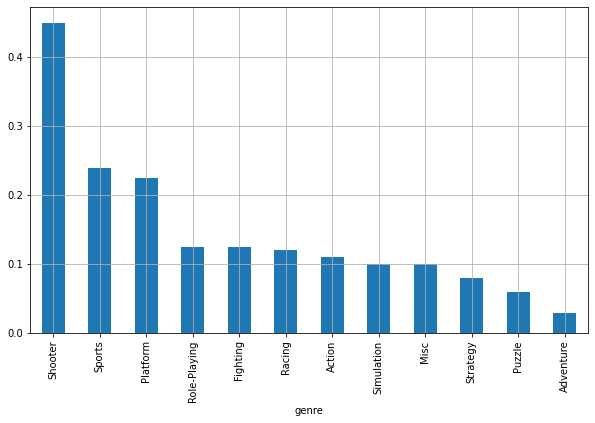

In [ ]:
genre_gr.plot(kind='bar', grid=True, figsize=(10, 6))

<AxesSubplot:title={'center':'total_sales'}, xlabel='genre'>

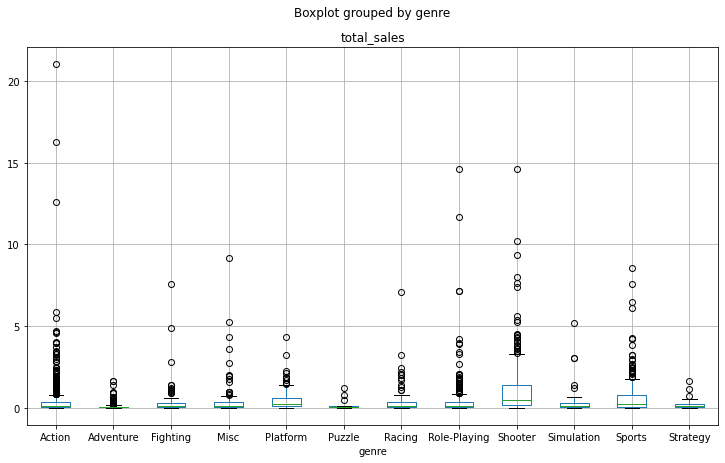

In [ ]:
data_new.boxplot(column='total_sales', by='genre', figsize=(12, 7))

(0.0, 3.5)

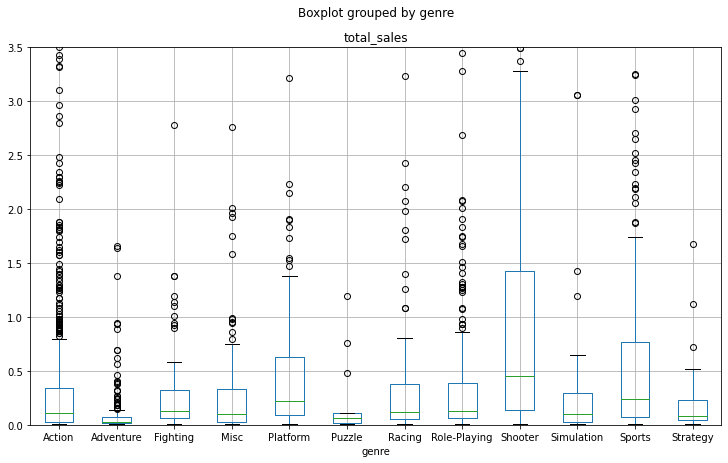

In [ ]:
data_new.boxplot(column='total_sales', by='genre', figsize=(12, 7))
plt.ylim(0, 3.5)

Наибольшие медианные продажи наблюдаются у таких жанров, как Shooter, Sports и Platform, а значит именно они имеют стабильно высокий спрос. У жанра Shooter, например, 75% всех продаж превышают медианные продажи большинства других жанров. Хуже остальных продаются игры, созданные в жанрах Adventure, Puzzle и Strategy.

## Портрет пользователя каждого региона

Найдем топ-5 самых популярных платформ для каждого региона:

,eu_sales,jp_sales,na_sales
platform,,,
3DS,30.96,67.81,38.20
DS,0.85,0.00,0.57
PC,25.36,0.00,11.11
PS3,67.81,23.35,63.50
PS4,141.09,15.96,108.74
PSP,0.17,3.29,0.00
PSV,6.10,18.59,5.04
Wii,5.93,0.05,6.56
WiiU,19.85,10.88,29.21


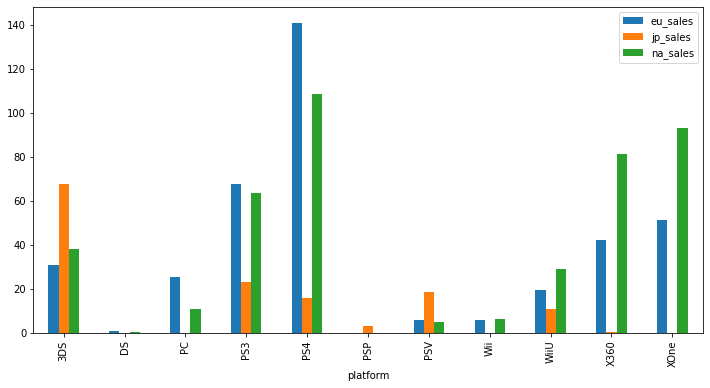

In [ ]:
#platform
region_pl = data_new.pivot_table(index='platform', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
region_pl.plot(kind='bar', figsize=(12, 6))
region_pl

In [ ]:
region_pl['eu_sales_share'] = region_pl['eu_sales'] / region_pl['eu_sales'].sum() * 100

In [ ]:
region_pl['jp_sales_share'] = region_pl['jp_sales'] / region_pl['jp_sales'].sum() * 100

In [ ]:
region_pl['na_sales_share'] = region_pl['na_sales'] / region_pl['na_sales'].sum() * 100

In [ ]:
region_pl.drop(columns=['eu_sales', 'jp_sales', 'na_sales'])

,eu_sales_share,jp_sales_share,na_sales_share
platform,,,
3DS,7.893328,48.167353,8.727239
DS,0.216710,0.000000,0.130223
PC,6.465594,0.000000,2.538210
PS3,17.288326,16.586163,14.507322
PS4,35.971241,11.336838,24.842933
PSP,0.043342,2.336980,0.000000
PSV,1.555210,13.205001,1.151447
Wii,1.511868,0.035516,1.498709
WiiU,5.060806,7.728371,6.673368


Самой популярной платформой за последние 5 лет в Европе стала PS3 (24% продавемых игр, выходили на этой платформе), в Японии - 3DS (41%), а в Северной Америке - X360 (27%). В меньшей степени пользуются спросом игры, выпускаемые на PS2 в Европе (0,02%) и Северной Америке (0,02%), а в Японии совершенно не продаются игры на PC.

Найдем топ-5 самых популярных жанров для каждого региона:

,eu_sales,jp_sales,na_sales
genre,,,
Action,118.13,40.49,126.05
Adventure,8.25,5.82,7.14
Fighting,8.55,7.65,15.55
Misc,20.04,9.20,27.49
Platform,15.58,4.79,18.14
Puzzle,1.00,1.18,0.83
Racing,20.19,2.30,12.96
Role-Playing,36.97,51.04,46.40
Shooter,87.86,6.61,109.74


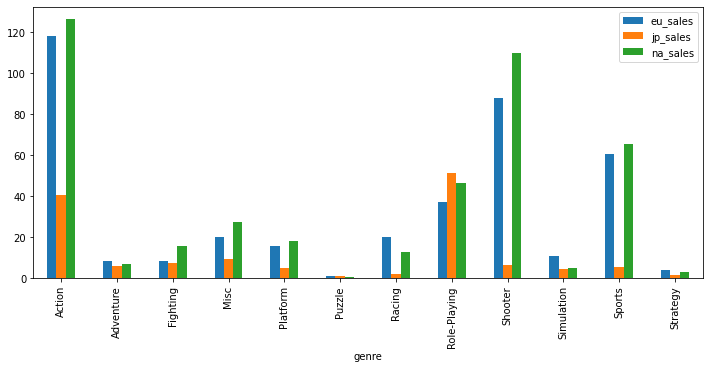

In [ ]:
#genre
region_genre = data_new.pivot_table(index='genre', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
region_genre.plot(kind='bar', figsize=(12, 5))
region_genre

In [ ]:
region_genre['eu_sales_share'] = region_genre['eu_sales'] / region_genre['eu_sales'].sum() * 100
region_genre['jp_sales_share'] = region_genre['jp_sales'] / region_genre['jp_sales'].sum() * 100
region_genre['na_sales_share'] = region_genre['na_sales'] / region_genre['na_sales'].sum() * 100

In [ ]:
region_genre.drop(columns=['eu_sales', 'jp_sales', 'na_sales'])

,eu_sales_share,jp_sales_share,na_sales_share
genre,,,
Action,30.117533,28.761188,28.797606
Adventure,2.103358,4.134110,1.631217
Fighting,2.179843,5.434011,3.552580
Misc,5.109247,6.535019,6.280414
Platform,3.972159,3.402472,4.144296
Puzzle,0.254952,0.838187,0.189623
Racing,5.147490,1.633755,2.960864
Role-Playing,9.425592,36.255150,10.600626
Shooter,22.400122,4.695269,25.071394


Самыми популярными жанрами на представленных рынках стали: Action в Европе (29%) и Северной Америке (27%), Role-Playing в Японии (32%). Наименьшей популярностью пользуется такой жанр, как Puzzle во всех перечисленных регионах (от 0,33% в Северной Америке до 1,18% в Японии).

Проверим, влияет ли рейтинг ESRB на продажи в отдельном регионе:

,eu_sales,jp_sales,na_sales
rating,,,
E,83.36,15.14,79.05
E10+,42.69,5.89,54.24
M,145.32,14.11,165.21
T,41.95,20.59,49.79
no_rating,78.91,85.05,89.42


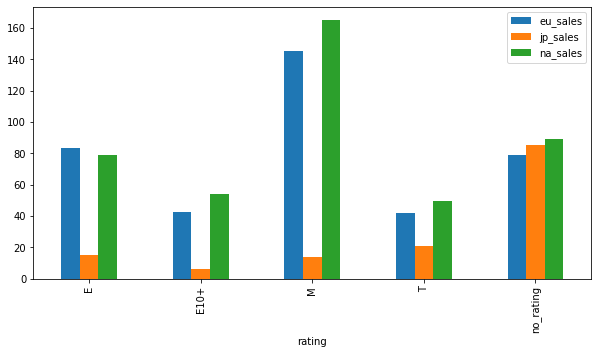

In [ ]:
#ESRB
region_esrb = data_new.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
region_esrb.plot(kind='bar', figsize=(10, 5))
region_esrb

In [ ]:
region_esrb['eu_sales_share'] = region_esrb['eu_sales'] / region_esrb['eu_sales'].sum() * 100
region_esrb['jp_sales_share'] = region_esrb['jp_sales'] / region_esrb['jp_sales'].sum() * 100
region_esrb['na_sales_share'] = region_esrb['na_sales'] / region_esrb['na_sales'].sum() * 100

In [ ]:
region_esrb.drop(columns=['eu_sales', 'jp_sales', 'na_sales'])

,eu_sales_share,jp_sales_share,na_sales_share
rating,,,
E,21.252836,10.754369,18.059903
E10+,10.883920,4.183833,12.391766
M,37.049690,10.022731,37.744169
T,10.695255,14.625657,11.375111
no_rating,20.118298,60.413411,20.429051


В Европе и Северной Америке самые высокие продажи можно наблюдать у игр с рейтингом М "Для взрослых" (по 37%), в Японии же самый популярный рейтинг E "Для всех возрастов" (10,7%), а также практически наравне с ним идет рейтинг M (10,02%). Самыми непопулярными можно назвать игры с рейтингом Т "Подросткам" в Европе и Северной Америке, и E10+ "Для всех от 10 лет и старше" в Японии.

Также стоит заметить, что более половины всех игр в Японии (60%) не имеют рейтинга, так как компания Entertainment Software Rating Board (ESRB) определяет рейтинги на игры США и Канады.

Исходя из представленного исследования популярности различных игр на дынных рынках, можно сделать вывод, что вкусы Европы и Северной Америки во многом схожи, в то время, как пользователи Японии заметно отличются в своих предпочтениях.

In [ ]:
temp = data_new.copy()
print(temp.rating.isna().sum(), temp.rating.isna().sum()/len(temp))
temp.rating.value_counts()

0 0.0


no_rating    977
M            369
T            333
E            302
E10+         252
Name: rating, dtype: int64

## Проверка гипотез

Проверим две интересующие нас гипотезы: о равенстве среднего пользовательского рейтинга платформ XOne и PC и жанров Action и Sports.

Так как все выборки для данных гипотез достаточно большие (более 200 значений) следует взять меньший уровень значимости (0,01).
Также, учитывая, что объемы у этих  выборок значительно отличаются друг от друга предполагаем, что дисперсии у генеральных совокупностей не равны и указываем параметр 'equal_var= False'.

Так как для проверки следующих гипотез мы будем проверять, равны ли средние двух генеральных совокупностей, мы используем Двухвыборочный t-критерий Стьдента, за который в питоне отвечает метод scipy.stats.ttest_ind().

In [ ]:
data_new.groupby('platform')['platform'].agg('count')

platform
3DS     303
DS        8
PC      189
PS3     345
PS4     392
PSP      67
PSV     358
Wii      23
WiiU    115
X360    186
XOne    247
Name: platform, dtype: int64

Исходя из задания формулируем нулевую гипотезу так, чтобы использовать знак равенства. В нашем случае это - средний пользовательский рейтинг платформы XOne равен среднему пользовательскому рейтингу PC. Альтернативная гипотеза должна противоречить нулевой так, что нулевая гипотеза либо принимается, либо отвергается и принимается альтернативная. Поэтому, гипотезу H1, как противоположную нулевой, формулируем так: средний пользовательский рейтинг платформы XOne не равен среднему пользовательскому рейтингу PC.

H0: средний пользовательский рейтинг платформы XOne равен среднему пользовательскому рейтингу PC;

H1: средний пользовательский рейтинг платформы XOne не равен среднему пользовательскому рейтингу PC.

In [ ]:
alpha = 0.01

results = st.ttest_ind(data_new.query('platform == "XOne"')['user_score'].dropna(), data_new.query('platform == "PC"')['user_score'].dropna(), equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.14759594013430463
Не получилось отвергнуть нулевую гипотезу


P-value показывает, что вероятность случайно получить такое или большее различие равна 61% и это слишком большая вероятность, чтобы говорить о значимом различии между средним пользовательским рейтингов у платформ XOne и PC.

In [ ]:
#средние пользовательские оценки
print(data_new[data_new['platform'] == 'XOne']['user_score'].mean())
data_new[data_new['platform'] == 'PC']['user_score'].mean()

6.521428571428572


6.269677419354839

По такому же принципу формулируем вторые, противоречащие друг другу, гипотезы о равенстве средних пользовательских рейтингов жанра Action и Sports:

H0: средний пользовательский рейтинг жанра Action равен среднему пользовательскому рейтингу жанра Sports;

H1: средний пользовательский рейтинг жанра Action не равен среднему пользовательскому рейтингу жанра Sports;

In [ ]:
data_new.groupby('genre')['genre'].agg('count')

genre
Action          766
Adventure       245
Fighting         80
Misc            155
Platform         74
Puzzle           17
Racing           85
Role-Playing    292
Shooter         187
Simulation       62
Sports          214
Strategy         56
Name: genre, dtype: int64

In [ ]:
alpha = 0.01

results = st.ttest_ind(data_new.query('genre == "Action"')['user_score'].dropna(), data_new.query('genre == "Sports"')['user_score'].dropna(), equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.4460039700704315e-20
Отвергаем нулевую гипотезу


Настолько маленькое значение P-value позволяет нам отвергнуть нулевую гипотезу и сказать, что средние пользовательские рейтинги жанров Action и Sports значительно отличаются.

In [ ]:
print(data_new[data_new['genre'] == 'Action']['user_score'].mean())
data_new[data_new['genre'] == 'Sports']['user_score'].mean()

6.837532133676093


5.238124999999999

## Общий вывод

В данном исследовании мы изучили исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы.
В результате было выявлено, что самыми перспективными платформами на данный момент являются PS4, XOne, 3DS, WiiU, а также
стабильно остается PC. К потенциально прибыльным жанрам можно отнести Action, Shooter, Role-Playing и Sports. Наблюдается, что
пользовательские рейтинги не имеют особого влияния на размеры продаж представленных игр, а оценки критиков влияют весьма
незначительно. Также, при запуске игры стоит заранее определиться с целевым рынком. Можно одновременно сделать ставку на Европу и Северную Америку, но, например, к Японии нужен совершенно другой подход.